* Data download - https://www.kaggle.com/rounakbanik/the-movies-dataset/data

In [ ]:
!pip install surprise

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings
warnings.simplefilter('ignore')

##### Reading the dataset

In [2]:
md = pd.read_csv(r'movies_metadata.csv')

In [8]:
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [17]:
# pd.set_option('display.width', -1)

In [23]:
md.genres[1]

"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]"

##### ast.literal_eval raises an exception if the input isn't a valid Python datatype, so the code won't be executed if it's not

In [9]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                   if isinstance(x, list) else [])

In [25]:
md.genres[1]

['Adventure', 'Fantasy', 'Family']

In [10]:
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


##### Simple Recommenders

As described in the previous section, simple recommenders are basic systems that recommends the top items based on a certain metric or score. In this section, you will build a simplified clone of IMDB Top 250 Movies using metadata collected from IMDB.

The following are the steps involved:

* Decide on the metric or score to rate movies on.
* Calculate the score for every movie.
* Sort the movies based on the score and output the top results.

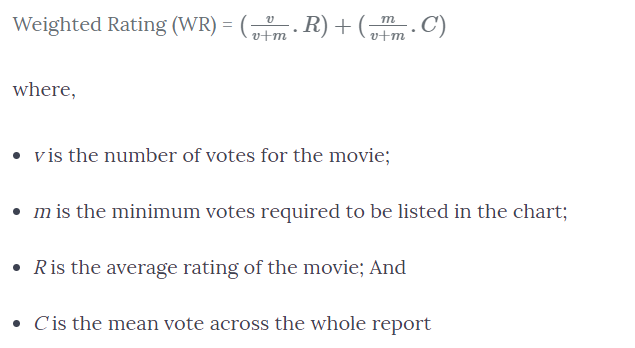

In [27]:
from IPython.display import Image
Image(filename='Weighted rating.png', width=400)

In [3]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean();C

##### The average rating of a movie on IMDB is around 5.2, on a scale of 10.

5.244896612406511

In [4]:
vote_counts.describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [5]:
m = vote_counts.quantile(0.90)
m

160.0

In [6]:
md['release_date'].head(2)

0    1995-10-30
1    1995-12-15
Name: release_date, dtype: object

In [7]:
md['release_date'].dtype

dtype('O')

In [8]:
md['year'] = pd.to_datetime(md['release_date'],errors ='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [9]:
md[['release_date', 'year']].head(2)

,release_date,year
0,1995-10-30,1995
1,1995-12-15,1995


In [10]:
# Filter out all qualified movies into a new DataFrame
q_movies = md.copy().loc[md['vote_count'] >= m]
q_movies.shape

(4555, 25)

In [11]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [12]:
q_movies['score'] = q_movies.apply(weighted_rating,axis=1)

In [13]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

In [14]:
q_movies[['title', 'year','vote_count', 'vote_average','genres', 'score']].head()

,title,year,vote_count,vote_average,genres,score
314,The Shawshank Redemption,1994,8358.0,8.5,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",8.438857
834,The Godfather,1972,6024.0,8.5,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",8.415780
10309,Dilwale Dulhania Le Jayenge,1995,661.0,9.1,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",8.348701
12481,The Dark Knight,2008,12269.0,8.3,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",8.260671
2843,Fight Club,1999,9678.0,8.3,"[{'id': 18, 'name': 'Drama'}]",8.250313


### Content-Based Recommender

Plot Description Based Recommender


In this section, you will try to build a system that recommends movies that are similar to a particular movie. More specifically, you will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score.

Let us build two Content Based Recommenders based on:

* Movie Overviews and Taglines
* Movie Cast, Crew, Keywords and Genre

##### Movie Description Based Recommender

In [15]:
links_small = pd.read_csv(r'links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [16]:
md = md.drop([19730, 29503, 35587])

In [17]:
md['id'] = md['id'].astype('int')

In [18]:
md.shape

(45463, 25)

In [19]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [20]:
smd.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995


In [21]:
smd.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year'],
      dtype='object')

In [22]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [23]:
pd.set_option('max_colwidth', -1)

In [24]:
print(smd['overview'].head())

0    Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.                                                                                            
1    When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.
2    A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarmin

In [25]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

In [26]:
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tf.fit_transform(smd['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

#You see that over 75,000 different words were used to describe the 45,000 movies in your dataset

(9099, 268124)

In [27]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [29]:
#Construct a reverse map of indices and movie titles
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

# indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [30]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return titles.iloc[movie_indices]

In [31]:
smd.columns

Index(['index', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year', 'description'],
      dtype='object')

In [32]:
smd.title.unique()

array(['Toy Story', 'Jumanji', 'Grumpier Old Men', ..., 'Mohenjo Daro',
       'Shin Godzilla',
       'The Beatles: Eight Days a Week - The Touring Years'], dtype=object)

In [33]:
get_recommendations('The Dark Knight Rises').head(10)

132     Batman Forever                         
6900    The Dark Knight                        
1113    Batman Returns                         
2579    Batman: Mask of the Phantasm           
524     Batman                                 
7565    Batman: Under the Red Hood             
7901    Batman: Year One                       
8227    Batman: The Dark Knight Returns, Part 2
6144    Batman Begins                          
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [34]:
get_recommendations('Mohenjo Daro').head()

1826    Children of a Lesser God               
2708    Sesame Street Presents Follow That Bird
5088    The Thief of Bagdad                    
6222    Corpse Bride                           
5881    Kirikou and the Sorceress              
Name: title, dtype: object

##### Metadata Based Recommender

Credits, Genres and Keywords Based Recommender

In [35]:
# Load keywords and credits
credits = pd.read_csv(r'credits.csv')
keywords = pd.read_csv(r'keywords.csv')

# Remove rows with bad IDs.
# md = md.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [70]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

In [60]:
# pd.set_option('max_colwidth', 20)
pd.reset_option('max_colwidth')

In [65]:
# Print the first two movies of your newly merged metadata
smd.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [39]:
smd.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year', 'cast', 'crew', 'keywords'],
      dtype='object')

In [67]:
# smd['cast'] = smd['cast'].apply(literal_eval)
# smd['crew'] = smd['crew'].apply(literal_eval)
# smd['keywords'] = smd['keywords'].apply(literal_eval)
# smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
# smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [71]:
smd[['cast','crew','keywords','genres']].head()

,cast,crew,keywords,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'id': 35, 'name': 'Comedy'}]"


In [72]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    smd[feature] = smd[feature].apply(literal_eval)

In [73]:
smd[['cast','crew','keywords','genres']].head()

,cast,crew,keywords,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'id': 35, 'name': 'Comedy'}]"


In [74]:
# Import Numpy 
import numpy as np

In [75]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [76]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [78]:
# Define new director, cast, genres and keywords features that are in a suitable form.
smd['director'] = smd['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    smd[feature] = smd[feature].apply(get_list)

In [79]:
# Print the new features of the first 3 films
smd[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [80]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [81]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    smd[feature] = smd[feature].apply(clean_data)

In [82]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [83]:
# Create a new soup feature
smd['soup'] = smd.apply(create_soup, axis=1)

In [85]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [86]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [87]:
# Reset index of your main DataFrame and construct reverse mapping as before
smd = smd.reset_index()
indices = pd.Series(smd.index, index=smd['title'])

In [89]:
get_recommendations('The Godfather', cosine_sim2)

1602    The Devil and Max Devlin
994                    Manhattan
5436                The Terminal
981                   Annie Hall
3300                 Left Behind
4148         Fox and His Friends
5                           Heat
380                Carlito's Way
904                  The Howling
1204                    Anaconda
Name: title, dtype: object

In [91]:
get_recommendations('Anaconda', cosine_sim2)

561     Mission: Impossible
1142                 Hamlet
2316         New Rose Hotel
3029                  X-Men
5283            The Killers
3105                Anatomy
4464     Permanent Vacation
7731                Cropsey
7419             The Chaser
7844           Fright Night
Name: title, dtype: object

https://github.com/rounakbanik/movies/blob/master/movies_recommender.ipynb

https://www.datacamp.com/community/tutorials/recommender-systems-python